# Setup & Import Libraries

In [2]:
!pip install pyspark -q

     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 199 kB 53.1 MB/s 


In [219]:
import pyspark.sql.functions as f
import pyspark.sql.types as t
import pyspark.sql.functions as f
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import os

from pyspark.ml  import Pipeline 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric

from sklearn.metrics import roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [87]:
# sc = SparkContext('local')
spark = SparkSession.builder.appName("Play with Pyspark").getOrCreate()

In [88]:
data_path = "data/data.csv"
data = spark.read.format("csv").load(data_path, header=True, ferSchema='True')

In [89]:
display(data)

DataFrame[age: string, anaemia: string, creatinine_phosphokinase: string, diabetes: string, ejection_fraction: string, high_blood_pressure: string, platelets: string, serum_creatinine: string, serum_sodium: string, sex: string, smoking: string, time: string, DEATH_EVENT: string]

In [90]:
data.show(5)

+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|age|anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
| 75|      0|                     582|       0|               20|                  1|   265000|             1.9|         130|  1|      0|   4|          1|
| 55|      0|                    7861|       0|               38|                  0|263358.03|             1.1|         136|  1|      0|   6|          1|
| 65|      0|                     146|       0|               20|                  0|   162000|             1.3|         129|  1|      1|   7|          1|
| 50|      1|                     111|       0|               20|     

# Data Overview

In [86]:
data.limit(3).toPandas()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75,0,582,0,20,1,265000,1.9,130,1,0,4,1
1,55,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65,0,146,0,20,0,162000,1.3,129,1,1,7,1


In [91]:
data.printSchema()

root
 |-- age: string (nullable = true)
 |-- anaemia: string (nullable = true)
 |-- creatinine_phosphokinase: string (nullable = true)
 |-- diabetes: string (nullable = true)
 |-- ejection_fraction: string (nullable = true)
 |-- high_blood_pressure: string (nullable = true)
 |-- platelets: string (nullable = true)
 |-- serum_creatinine: string (nullable = true)
 |-- serum_sodium: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- smoking: string (nullable = true)
 |-- time: string (nullable = true)
 |-- DEATH_EVENT: string (nullable = true)



In [34]:
selected_data = data.selectExpr("time as Time", "age as Age", "sex as Sex",
                                "smoking as Smoking")

display(selected_data)

DataFrame[Time: string, Age: string, Sex: string, Smoking: string]

In [35]:
data.count()

299

In [36]:
selected_data.select("Age").count()

299

In [37]:
selected_data.select("Age").distinct().count()

47

In [38]:
selected_data.select("Age").distinct().show(10)

+---+
|Age|
+---+
| 51|
| 54|
| 69|
| 42|
| 87|
| 73|
| 64|
| 59|
| 85|
| 52|
+---+
only showing top 10 rows



In [24]:
display(selected_data.select("Smoking").distinct().show(5))

+-------+
|Smoking|
+-------+
|      0|
|      1|
+-------+



None

In [42]:
display(selected_data.filter("Smoking == 1").show(5))

+----+---+---+-------+
|Time|Age|Sex|Smoking|
+----+---+---+-------+
|   7| 65|  1|      1|
|   8| 90|  1|      1|
|  10| 60|  1|      1|
|  10| 80|  1|      1|
|  10| 75|  1|      1|
+----+---+---+-------+
only showing top 5 rows



None

In [29]:
selected_data.filter("Smoking == 1").count()

96

In [30]:
selected_data.filter("Smoking == 0").count()

203

In [49]:
num_females = selected_data.filter("Sex == 0").count()
num_males = selected_data.filter("Sex == 1").count()

In [50]:
num_females_smoking = selected_data.filter("Sex == 0").filter("Smoking == 1").count()
num_males_smoking = selected_data.filter("Sex == 1").filter("Smoking == 1").count()

In [51]:
print(f"Percentage of woman smokin: {num_females_smoking*100/num_females:.2f}")
print(f"Percentage of men smoking: {num_males_smoking*100/num_males:.2f}")

Percentage of woman smokin: 3.81
Percentage of men smoking: 47.42


# Exploratory Data Analsysis

In [76]:
sns.set(rc={'figure.figsize':(10, 5)})

Text(0.5, 1.0, 'Age distribution among all Peoples')

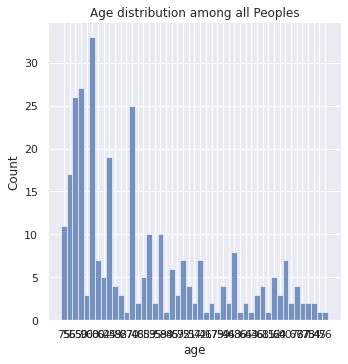

In [77]:
df_pandas = data.toPandas()

# fig = plt.figure(figsize=(10, 5))
sns.displot(df_pandas["age"]);
plt.title("Age distribution among all Peoples")

Text(0.5, 1.0, 'Age distribution among all Peoples')

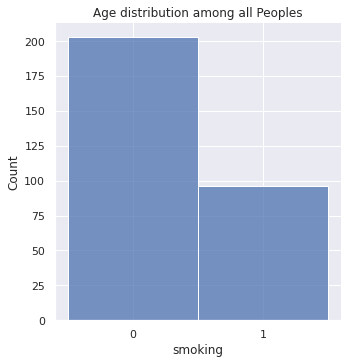

In [79]:

sns.displot(df_pandas["smoking"]);
plt.title("Smoking distribution among all Peoples")

**Checking for Missin Values**

In [81]:
data.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|age|anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|  0|      0|                       0|       0|                0|                  0|        0|               0|           0|  0|      0|   0|          0|
+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+



# Machine Learning in PySpark

**Split up into train and test**

In [97]:
stringIndexer = StringIndexer(inputCol='sex', outputCol='sex_new')
# Applying stringindexer object on dataframe movie title column
model = stringIndexer.fit(data)
#creating new dataframe with transformed values
indexed = model.transform(data)
#validate the numerical title values
indexed.limit(5).toPandas()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,sex_new
0,75,0,582,0,20,1,265000,1.9,130,1,0,4,1,0.0
1,55,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,0.0
2,65,0,146,0,20,0,162000,1.3,129,1,1,7,1,0.0
3,50,1,111,0,20,0,210000,1.9,137,1,0,7,1,0.0
4,65,1,160,1,20,0,327000,2.7,116,0,0,8,1,1.0


In [195]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data) for column in ["smoking", "age","anaemia","creatinine_phosphokinase",
                                                                                            "diabetes", "ejection_fraction", "high_blood_pressure",
                                                                                             "platelets", "serum_sodium", "serum_creatinine", "sex",
                                                                                              "time", "DEATH_EVENT"]]
pipeline = Pipeline(stages=indexers)

In [196]:
df = pipeline.fit(data).transform(data)

df.limit(3).toPandas()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,...,creatinine_phosphokinase_index,diabetes_index,ejection_fraction_index,high_blood_pressure_index,platelets_index,serum_sodium_index,serum_creatinine_index,sex_index,time_index,DEATH_EVENT_index
0,75,0,582,0,20,1,265000,1.9,130,1,...,0.0,0.0,8.0,1.0,21.0,11.0,13.0,0.0,125.0,1.0
1,55,0,7861,0,38,0,263358.03,1.1,136,1,...,186.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,134.0,1.0
2,65,0,146,0,20,0,162000,1.3,129,1,...,61.0,0.0,8.0,0.0,31.0,18.0,5.0,0.0,62.0,1.0


In [197]:
df.printSchema()

root
 |-- age: string (nullable = true)
 |-- anaemia: string (nullable = true)
 |-- creatinine_phosphokinase: string (nullable = true)
 |-- diabetes: string (nullable = true)
 |-- ejection_fraction: string (nullable = true)
 |-- high_blood_pressure: string (nullable = true)
 |-- platelets: string (nullable = true)
 |-- serum_creatinine: string (nullable = true)
 |-- serum_sodium: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- smoking: string (nullable = true)
 |-- time: string (nullable = true)
 |-- DEATH_EVENT: string (nullable = true)
 |-- smoking_index: double (nullable = false)
 |-- age_index: double (nullable = false)
 |-- anaemia_index: double (nullable = false)
 |-- creatinine_phosphokinase_index: double (nullable = false)
 |-- diabetes_index: double (nullable = false)
 |-- ejection_fraction_index: double (nullable = false)
 |-- high_blood_pressure_index: double (nullable = false)
 |-- platelets_index: double (nullable = false)
 |-- serum_sodium_index: double (

## Feature Engineering

In [198]:
df = df.drop("age","anaemia","creatinine_phosphokinase", "diabetes", 
             "ejection_fraction", "high_blood_pressure", "platelets", 
             "serum_sodium", "serum_creatinine", "sex", "smoking", 
             "time", "DEATH_EVENT")

In [199]:
df.printSchema()

root
 |-- smoking_index: double (nullable = false)
 |-- age_index: double (nullable = false)
 |-- anaemia_index: double (nullable = false)
 |-- creatinine_phosphokinase_index: double (nullable = false)
 |-- diabetes_index: double (nullable = false)
 |-- ejection_fraction_index: double (nullable = false)
 |-- high_blood_pressure_index: double (nullable = false)
 |-- platelets_index: double (nullable = false)
 |-- serum_sodium_index: double (nullable = false)
 |-- serum_creatinine_index: double (nullable = false)
 |-- sex_index: double (nullable = false)
 |-- time_index: double (nullable = false)
 |-- DEATH_EVENT_index: double (nullable = false)



In [200]:
feature = VectorAssembler(inputCols = df.columns[1:],outputCol="features")
feature_vector= feature.transform(df)
feature_vector.limit(3).toPandas()

,smoking_index,age_index,anaemia_index,creatinine_phosphokinase_index,diabetes_index,ejection_fraction_index,high_blood_pressure_index,platelets_index,serum_sodium_index,serum_creatinine_index,sex_index,time_index,DEATH_EVENT_index,features
0,0.0,6.0,0.0,0.0,0.0,8.0,1.0,21.0,11.0,13.0,0.0,125.0,1.0,"[6.0, 0.0, 0.0, 0.0, 8.0, 1.0, 21.0, 11.0, 13...."
1,0.0,5.0,0.0,186.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,134.0,1.0,"(5.0, 0.0, 186.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0..."
2,1.0,2.0,0.0,61.0,0.0,8.0,0.0,31.0,18.0,5.0,0.0,62.0,1.0,"[2.0, 0.0, 61.0, 0.0, 8.0, 0.0, 31.0, 18.0, 5...."


In [201]:
dataset = feature_vector.select(['features','smoking_index'])
# Split the dataset to train_df and test_df
train_df, test_df = dataset.randomSplit([0.75,0.25])

In [202]:
train_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- smoking_index: double (nullable = false)



**Just for pratice, I'll Build a Classifier for known the probability if the user smoke or not.**

In [203]:
model = LogisticRegression(labelCol="smoking_index")

## Build Model Pipeline

In [204]:
paramGrid = ParamGridBuilder().addGrid(model.regParam, (0.01, 0.1))\
                              .addGrid(model.maxIter, (5, 10))\
                              .addGrid(model.tol, (1e-4, 1e-5))\
                              .addGrid(model.elasticNetParam, (0.25,0.75))\
                              .build()

In [205]:
tvs = TrainValidationSplit(estimator=model,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator(labelCol='smoking_index'),
                           trainRatio=0.8)

In [206]:
model = tvs.fit(train_df)

In [207]:
model_predictions = model.transform(test_df)

# Evaluation

In [208]:
acc = MulticlassClassificationEvaluator(labelCol='smoking_index',metricName='accuracy').evaluate(model_predictions)

In [209]:
recall = MulticlassClassificationEvaluator(labelCol="smoking_index",
                                           metricName="weightedRecall").evaluate(model_predictions)

In [210]:
precision = MulticlassClassificationEvaluator(labelCol="smoking_index",
                                              metricName="weightedPrecision").evaluate(model_predictions)

In [211]:
print(f"Accuracy: {acc:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

Accuracy: 0.64
Recall: 0.64
Precision: 0.65


**evaluating ROC metric**

In [217]:
import warnings
warnings.filterwarnings(action="ignore")
sc = SparkContext.getOrCreate()
results = model_predictions.select(["probability",
                                    "smoking_index"])
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print(f"ROC score: {metrics.areaUnderROC:.2f}")

ROC score: 0.70


**Plot AUC**

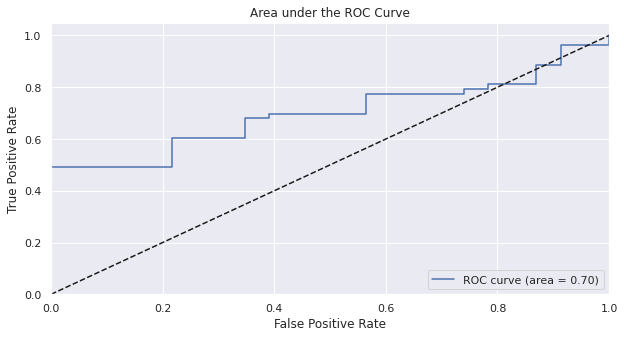

In [222]:
fpr, tpr = dict(), dict()
roc_auc = dict()

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area under the ROC Curve")
plt.legend(loc="lower right")
plt.show()